In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

In [39]:
pd.set_option("display.max_row", 200)

In [40]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)

In [41]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 20  # use 7 days
OUT_STEPS = 1  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [42]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series)

In [43]:
a, b = test_window.example


In [44]:
lstm_model_classifier = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

MAX_EPOCHS = 5

In [45]:
def compile_and_fit_classifier(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # model.compile(loss=tf.keras.losses.MeanSquaredError(),
    #               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
    #               metrics=[tf.keras.metrics.MeanAbsoluteError()])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [46]:
history = compile_and_fit_classifier(lstm_model_classifier, test_window)
val_performance = {}
performance = {}

probs = lstm_model_classifier.predict(test_window.val)
preds = probs.argmax(axis=-1)
val_performance['LSTM'] = lstm_model_classifier.evaluate(test_window.val, verbose=0)

probs = lstm_model_classifier.predict(test_window.test)
preds = probs.argmax(axis=-1)
performance['LSTM'] = lstm_model_classifier.evaluate(test_window.test, verbose=0)

Epoch 1/5
61/61 [==============================] - 12s 65ms/step - loss: 1.3312 - sparse_categorical_accuracy: 0.4300 - val_loss: 0.4369 - val_sparse_categorical_accuracy: 0.8056
Epoch 2/5
61/61 [==============================] - 3s 35ms/step - loss: 0.9807 - sparse_categorical_accuracy: 0.4362 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8056
Epoch 3/5
61/61 [==============================] - 3s 42ms/step - loss: 0.9197 - sparse_categorical_accuracy: 0.4588 - val_loss: 0.4227 - val_sparse_categorical_accuracy: 0.7963
Epoch 4/5
24/24 [==============================] - 2s 15ms/step


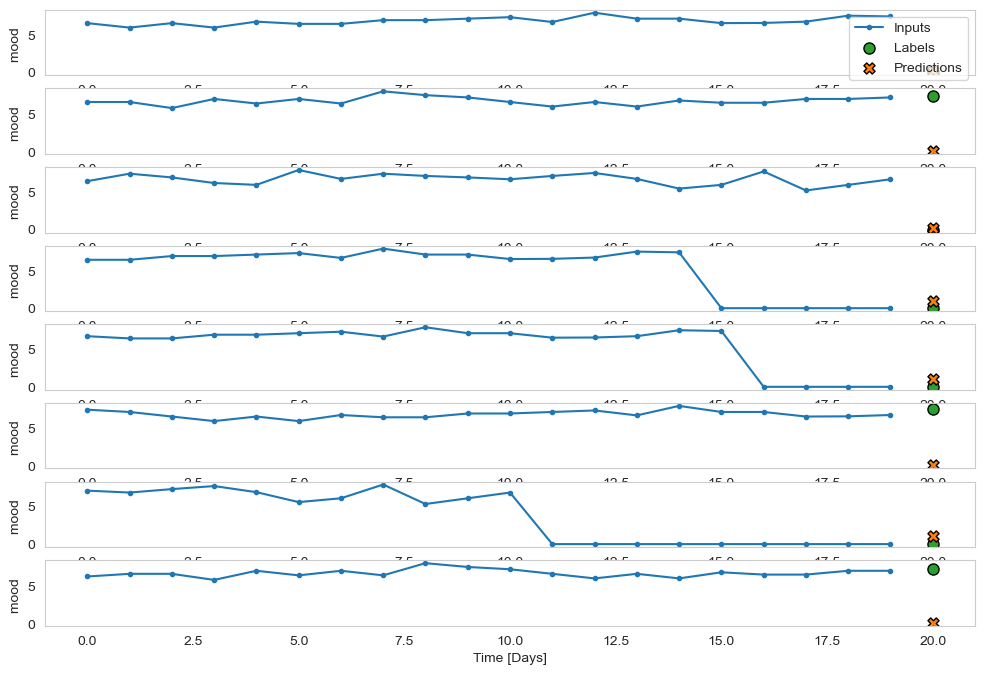

In [47]:
test_window.plot(lstm_model_classifier, single=True, max_subplots=10)

In [48]:
a, b = test_window.example
lstm_model_classifier(a)

<tf.Tensor: shape=(8, 10), dtype=float32, numpy=
array([[1.64676294e-01, 5.68774482e-03, 3.33316042e-03, 5.82002755e-03,
        1.03055863e-02, 2.42660567e-02, 2.91026115e-01, 3.84684384e-01,
        1.03249006e-01, 6.95149601e-03],
       [1.74604550e-01, 5.10042394e-03, 3.18846456e-03, 6.19689422e-03,
        8.46175198e-03, 2.80180722e-02, 2.58270562e-01, 4.28508490e-01,
        8.09386149e-02, 6.71218894e-03],
       [1.58380732e-01, 3.23751429e-03, 2.18084734e-03, 4.10109572e-03,
        5.79257123e-03, 2.42589135e-02, 2.87210792e-01, 4.45618510e-01,
        6.48693964e-02, 4.34966665e-03],
       [9.96870220e-01, 1.01429468e-04, 2.24523810e-05, 1.14916118e-04,
        1.64962243e-04, 6.55619311e-04, 4.35954920e-04, 1.16160500e-03,
        3.83819453e-04, 8.91451273e-05],
       [9.95994568e-01, 1.21779049e-04, 2.80397271e-05, 1.38869684e-04,
        2.01288145e-04, 8.17105349e-04, 5.48026641e-04, 1.54831342e-03,
        4.92584950e-04, 1.09401735e-04],
       [1.61344633e-01, 5.